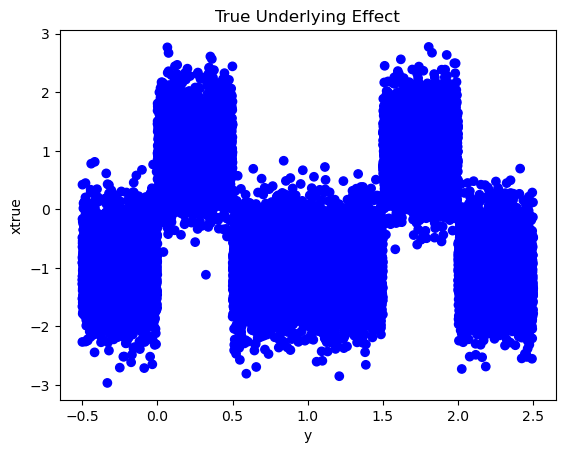

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
# Set random seed for reproducibility
np.random.seed(1)
torch.manual_seed(1)

# Generate data
n_samples = 20000
y = np.random.uniform(-.5, 2.5, n_samples)
X = y.reshape(-1, 1)
xtrue = np.zeros_like(y)

# Apply conditions to generate xtrue based on y
for i in range(len(xtrue)):
    if (0 < y[i] < 0.5) or (1.5 < y[i] < 2):
        xtrue[i] = np.random.normal(1, scale=0.5 )
    else:
        xtrue[i] = np.random.normal(-1, scale=0.5 )

# Generate x and s
x = xtrue + np.random.normal(0, 1, len(xtrue))
s = np.ones_like(x)
Z = np.ones((n_samples, 1))

# Plot the results
plt.scatter(y, xtrue, c=np.where(xtrue == 0, 'green', 'blue'))
plt.title('True Underlying Effect')
plt.xlabel('y')
plt.ylabel('xtrue')
plt.show()


In [2]:
# Assuming we have the comoR functions implemented in Python
# For now, we'll create dummy data for fit_como.data_loglik
num_classes = 20

import os
import sys
sys.path.append(r"c:\Document\Serieux\Travail\python_work\cEBNM_torch\py")
# Import utils.py directly
from utils import *
from numerical_routine import *
from distribution_operation import *
from posterior_computation import *
from ash import *
scale = autoselect_scales_mix_norm(betahat=x,
                                   sebetahat=np.full(x.shape[0],1),
                                       max_class=num_classes) 

 
print(scale.shape)
scale[0]=scale[2]
scale[1]=scale[2]


(20,)


In [3]:
fit_como_data_loglik = get_data_loglik_normal(betahat=x,
                                              sebetahat=np.full(x.shape[0],1),
                                               location=0*scale,
                                              scale=scale)

In [4]:




 
# Convert data to PyTorch tensors
x_train = torch.FloatTensor(y).reshape(-1, 1) 
y_train = torch.FloatTensor(fit_como_data_loglik)

# Define the model
class SimpleNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleNet, self).__init__()
        # Common layers
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)

        # Head for pred_pi (weights that sum up to 1)
        self.fc_pi = nn.Linear(hidden_size, num_classes)
        self.softmax = nn.Softmax(dim=1)

        # Head for location (continuous values)
        self.fc_location = nn.Linear(hidden_size, num_classes)

        self.relu = nn.ReLU()

    def forward(self, x):
        # Shared layers
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))

        # Head for pred_pi
        pred_pi = self.softmax(self.fc_pi(x))

        # Head for location
        location=   self.fc_location(x)  

        return pred_pi, location


# Custom loss function
def custom_loss(pred_pi, marginal_log_lik):
    return -torch.sum(torch.log(torch.sum(torch.exp(marginal_log_lik) * pred_pi, dim=1)))
def custom_loss(pred_pi, marginal_log_lik, penalty=1.1 , epsilon=1e-10):
    
    """
    Compute the penalized log likelihood function using vectorized operations.

    Parameters:
    pred_pi (torch.Tensor): A tensor of shape (batch_size, K) corresponding to pi_k for each sample.
    marginal_log_lik (torch.Tensor): A tensor of shape (batch_size, K) corresponding to the log-likelihoods.
    penalty (float): The penalty term.
    epsilon (float): Small constant to avoid log of zero or division by zero.

    Returns:
    torch.Tensor: The negative penalized log likelihood (for minimization purposes).
    """
    # Compute L_batch as the exponentiated marginal_log_lik (this is vectorized across all rows)
    L_batch = torch.exp(marginal_log_lik)
     
    
    # Element-wise multiplication between pred_pi and L_batch, sum over the components (columns)
    inner_sum = torch.sum(pred_pi * L_batch, dim=1)
    # Ensure inner_sum is not too small to avoid log(0) or log(negative)
    inner_sum = torch.clamp(inner_sum, min=epsilon) 
     
    # Compute the first sum: sum of log(inner_sum) across the minibatch (batch_size)
    first_sum = torch.sum(torch.log(inner_sum))
     
    # Penalty term: based on the first component of pred_pi (penalty on pred_pi[:, 0])
    if penalty > 1:
        pi_clamped = torch.clamp(torch.sum(pred_pi[:, 0]), min=epsilon)
        penalized_log_likelihood_value = first_sum + (penalty - 1) * torch.log(pi_clamped)
    else:
        penalized_log_likelihood_value = first_sum

    # Return the negative of the penalized log-likelihood
    return -penalized_log_likelihood_value

    

In [5]:


# Initialize model
model = SimpleNet(1, 64, num_classes)

# Define optimizer
optimizer = optim.Adam(model.parameters())

# Training loop
num_epochs = 100
batch_size = 500

for epoch in range(num_epochs):
    for i in range(0, len(x_train), batch_size):
        batch_x = x_train[i:i+batch_size]
        
        pred_pi, location = model(batch_x)
       
        batch_y = torch.FloatTensor( get_data_loglik_normal(betahat=x[i:i+batch_size],
                                      sebetahat=np.full(x[i:i+batch_size].shape[0],1),
                                      location=location.detach() .numpy() ,  # Use .detach() before .numpy()
                                      scale=scale))
 
        
        optimizer.zero_grad() 
        loss = custom_loss(pred_pi=  pred_pi, 
                           marginal_log_lik= batch_y)
        loss.backward()
        optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

 

Epoch [10/100], Loss: 928.6802
Epoch [20/100], Loss: 916.9955
Epoch [30/100], Loss: 921.1465
Epoch [40/100], Loss: 926.3481
Epoch [50/100], Loss: 931.7146
Epoch [60/100], Loss: 937.2247
Epoch [70/100], Loss: 942.8369
Epoch [80/100], Loss: 948.9882
Epoch [90/100], Loss: 966.7094
Epoch [100/100], Loss: 974.3256


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from posterior_computation import posterior_mean_norm  # Ensure this import works

# [Previous code for data generation and model definition remains the same]

# After training the model, compute the posterior mean
model.eval()
with torch.no_grad():
    all_pi_values,all_location = model(x_train)

all_pi_values_np = all_pi_values.numpy()
all_location_np =all_location.numpy()
 
 

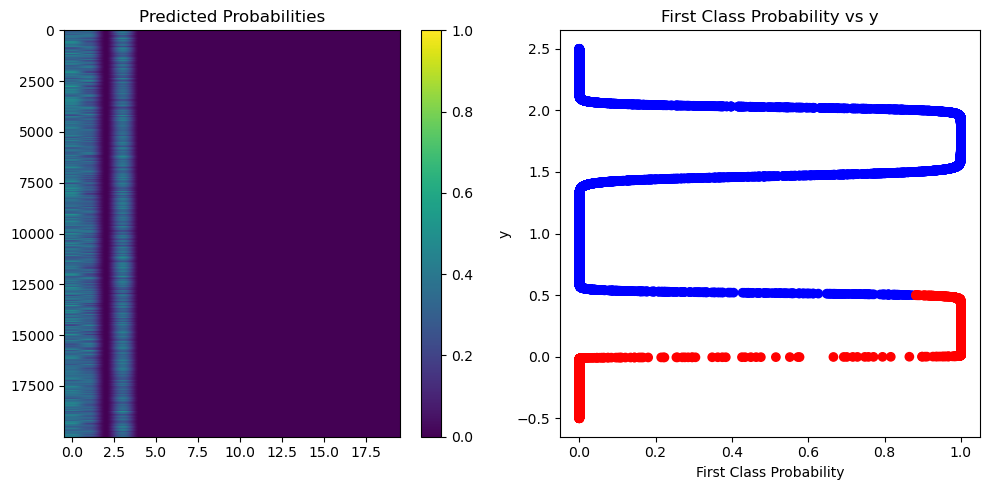

In [7]:
# Plotting
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(all_pi_values, aspect='auto')
plt.title('Predicted Probabilities')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.scatter(all_pi_values[:, 0], y, c=['red' if yi < 0.5 else 'blue' for yi in y])
plt.title('First Class Probability vs y')
plt.xlabel('First Class Probability')
plt.ylabel('y')

plt.tight_layout()
plt.show()

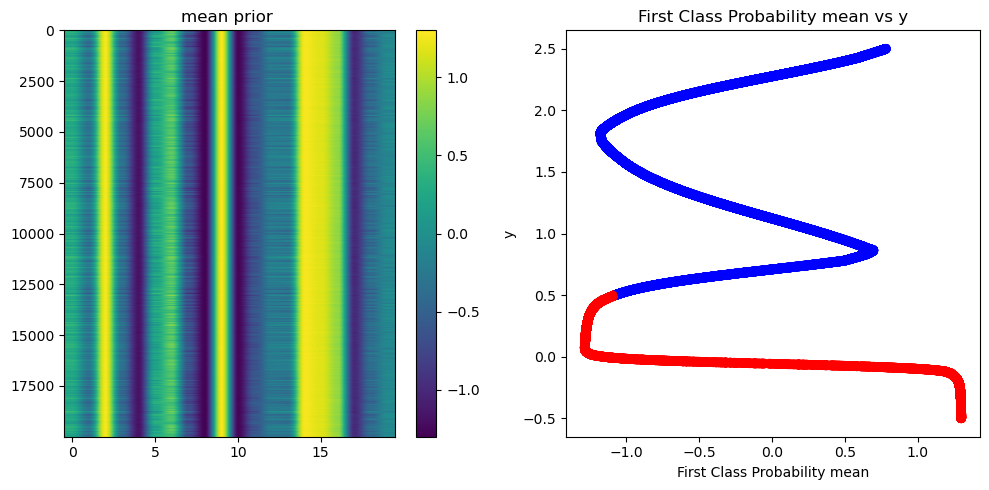

In [8]:
# Plotting
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(all_location, aspect='auto')
plt.title('mean prior ')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.scatter(all_location[:, 1], y, c=['red' if yi < 0.5 else 'blue' for yi in y])
plt.title('First Class Probability mean vs y')
plt.xlabel('First Class Probability mean')
plt.ylabel('y')

plt.tight_layout()
plt.show()

In [9]:
betahat=np.array([x[i]])
sebetahat=np.array([s[i]])
log_pi=np.log(all_pi_values_np[i, :])
location= all_location_np[i,:]
scale= scale  # Assuming this is available from earlier in your code


In [10]:
from utils import *
from numerical_routine import *
from distribution_operation import *
from posterior_computation import *
from ash import *

In [11]:
est_post = np.zeros(n_samples)
for i in range(n_samples):
  
    est_post[i] = posterior_mean_norm(
        betahat=np.array([x[i]]),
        sebetahat=np.array([s[i]]),
        log_pi=np.log(all_pi_values_np[i, :]),
        location= all_location_np[i,:],
        scale= scale  # Assuming this is available from earlier in your code
    ).post_mean
 

C:\Users\willi\AppData\Local\Temp\ipykernel_6652\1593073801.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  est_post[i] = posterior_mean_norm(
C:\Users\willi\AppData\Local\Temp\ipykernel_6652\1593073801.py:7: RuntimeWarning: divide by zero encountered in log
  log_pi=np.log(all_pi_values_np[i, :]),


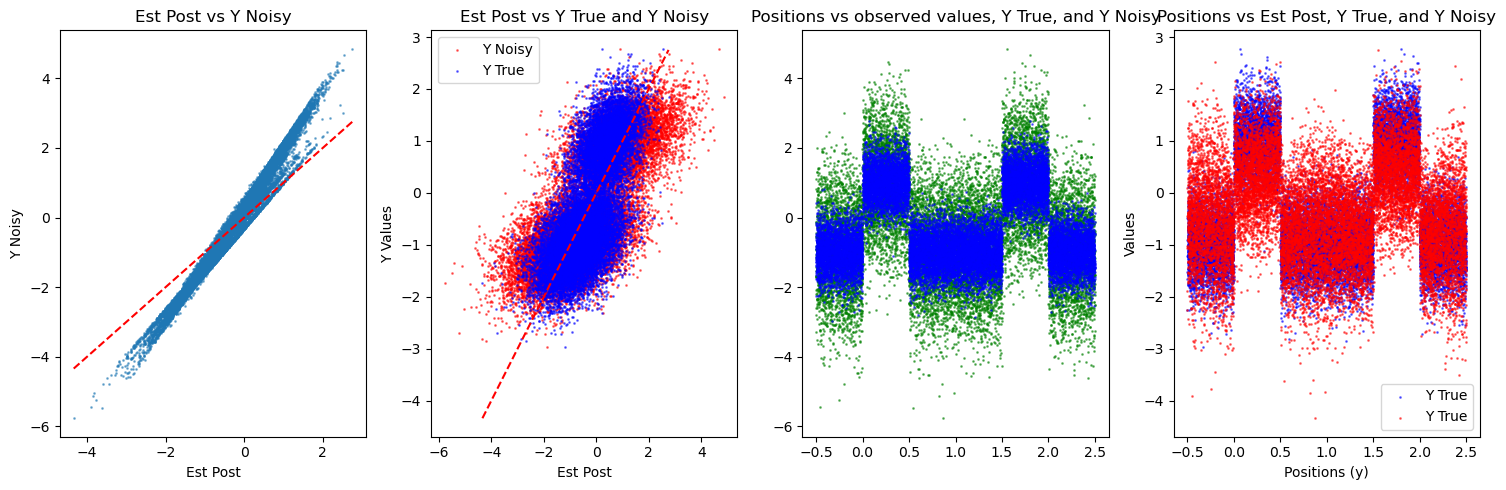


Mean Squared Error:
MSE (Est Post vs Y Noisy): 1.0099
MSE (Ash Post vs Y True): 0.5893
MSE (Est Post vs Y True): 0.6428


In [12]:
plt.figure(figsize=(15, 5))

# Plot 1: Est Post vs Y Noisy
plt.subplot(1, 4, 1)
plt.scatter(est_post, x, alpha=0.5, s=1)
plt.title('Est Post vs Y Noisy')
plt.xlabel('Est Post')
plt.ylabel('Y Noisy')
plt.plot([min(est_post), max(est_post)], [min(est_post), max(est_post)], 'r--')

# Plot 2: Est Post vs Y True
plt.subplot(1, 4, 2)
plt.scatter(x, xtrue, alpha=0.5, s=1, label='Y Noisy', color='red')

plt.scatter(est_post, xtrue, alpha=0.5, s=1, label='Y True', color='blue')
plt.title('Est Post vs Y True and Y Noisy')
plt.xlabel('Est Post')
plt.ylabel('Y Values')
plt.legend()
plt.plot([min(est_post), max(est_post)], [min(est_post), max(est_post)], 'r--')

# Plot 3: Positions vs Est Post, Y True, and Y Noisy
plt.subplot(1, 4, 3)
#plt.scatter(y, y_n_np, alpha=0.5, s=1, label='Y Noisy', color='red')

plt.scatter(y, x, alpha=0.5, s=1, label='Y True', color='green')
plt.scatter(y, xtrue, alpha=0.5, s=1, label='Y True', color='blue')
#plt.scatter(y, x, alpha=0.5, s=1, label='Y True', color='green')
plt.title('Positions vs observed values, Y True, and Y Noisy')
plt.subplot(1,4,4)
plt.scatter(y, xtrue, alpha=0.5, s=1, label='Y True', color='blue')

plt.scatter(y, est_post, alpha=0.5, s=1, label='Y True', color='red')
plt.title('Positions vs Est Post, Y True, and Y Noisy')
plt.xlabel('Positions (y)')
plt.ylabel('Values')
plt.legend()

plt.tight_layout()
plt.show()
res_ash = ash( x, np.full(x .shape[0],1))
# Print some statistics
 
# Calculate and print MSE
mse_noisy = np.mean((xtrue - x)**2)
mse_ash = np.mean (( res_ash.post_mean - xtrue)**2)

mse_true = np.mean((est_post - xtrue)**2)
print(f"\nMean Squared Error:")
print(f"MSE (Est Post vs Y Noisy): {mse_noisy:.4f}")
print(f"MSE (Ash Post vs Y True): {mse_ash:.4f}")
print(f"MSE (Est Post vs Y True): {mse_true:.4f}")



In [13]:
from ash import *
res_ash = ash( x, np.full(x .shape[0],1))

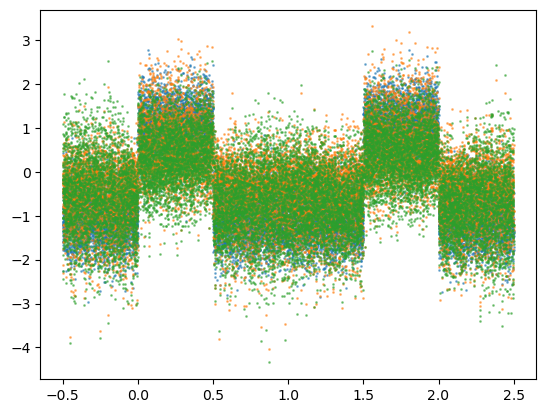

In [14]:
plt.scatter(y, xtrue, alpha=0.5, s=1, label='Y True' )
plt.scatter(y, res_ash.post_mean, alpha=0.5, s=1, label='Y True' )
plt.scatter(y, est_post, alpha=0.5, s=1, label='Y True' )

